In [36]:
from src.utils import data_load
import pandas as pd
from src.s3_utils import pandas_from_csv_s3
import numpy as np

In [37]:
data = data_load(data_keys={'bodyport', 'oura_activity', 'oura_sleep'})


In [38]:
data['bodyport']['subsource'].unique()
# subsource is only `weight`

array(['weight'], dtype=object)

In [39]:
data_bodyport = data['bodyport']
users = data_bodyport['user_id'].unique().tolist()
most_data_user = -1
most_data = -1
for u in users:
    num_data = len(data_bodyport[data_bodyport['user_id'] == u])
    if num_data > most_data:
        most_data = num_data
        most_data_user = u
most_data_user
# userid 74 has the most data

74

In [40]:
data_bodyport.columns.tolist()

['id',
 'user_id',
 'identity_id',
 'created_at',
 'updated_at',
 'retrieved_at',
 'subsource',
 'creation_date',
 'event_date',
 'backend_sway_area_mm2',
 'bmi_kg_m2',
 'device_id',
 'end_code',
 'heart_rate',
 'impedance_mag_1_ohms',
 'impedance_phase_1_degs',
 'impedance_ratio',
 'muuid',
 'patient_id',
 'peripheral_fluid',
 'run_time_sec',
 'sway_velocity_mm_sec',
 'total_body_water_percent',
 'uuid',
 'weight_kg',
 'date']

In [58]:
selected_data_bodyport = data_bodyport[data_bodyport['user_id'] == 74][['date', 'impedance_ratio', 'peripheral_fluid', 'impedance_mag_1_ohms', 'impedance_phase_1_degs', 'weight_kg']].groupby("date", as_index = False).mean()


In [42]:
data_oura_activity = data['oura_activity']
data_oura_activity[data_oura_activity['user_id'] == 74]
data_oura_sleep = data['oura_sleep']
# target_user_sleep = data_oura_sleep[data_oura_sleep['user_id'] == 74]
# target_user_sleep[['hr_5min', 'date']]

In [43]:
data_oura_activity.columns.tolist()

['id',
 'user_id',
 'identity_id',
 'created_at',
 'updated_at',
 'retrieved_at',
 'subsource',
 'event_date',
 'average_met',
 'cal_active',
 'cal_total',
 'class_5min',
 'daily_movement',
 'day_end',
 'day_start',
 'high',
 'inactive',
 'inactivity_alerts',
 'low',
 'medium',
 'met_1min',
 'met_min_high',
 'met_min_inactive',
 'met_min_low',
 'met_min_medium',
 'non_wear',
 'rest',
 'rest_mode_state',
 'score',
 'score_meet_daily_targets',
 'score_move_every_hour',
 'score_recovery_time',
 'score_stay_active',
 'score_training_frequency',
 'score_training_volume',
 'steps',
 'target_calories',
 'target_km',
 'target_miles',
 'timezone',
 'to_target_km',
 'to_target_miles',
 'total',
 'date']

In [76]:
selected_data_oura_activity = data_oura_activity[data_oura_activity['user_id'] == 74][[
 'cal_active',
 'cal_total',
 'daily_movement',
 'high',
 'inactive',
 'inactivity_alerts',
 'low',
 'medium',
 'met_min_high',
 'met_min_inactive',
 'met_min_low',
 'met_min_medium',
 'non_wear',
 'rest',
 'rest_mode_state',
#  'score',
#  'score_meet_daily_targets',
#  'score_move_every_hour',
#  'score_recovery_time',
#  'score_stay_active',
#  'score_training_frequency',
#  'score_training_volume',
 'steps',
 'date']]

In [63]:
def get_min_date(df):
    return np.min(df['date'])
def get_max_date(df):
    return np.max(df['date'])

In [88]:

# # union
# overall_min_date = np.min([get_min_date(selected_data_bodyport), get_min_date(selected_data_oura_activity)])
# overall_max_date = np.max([get_max_date(selected_data_bodyport), get_max_date(selected_data_oura_activity)])

# intercept
overall_min_date = np.max([get_min_date(selected_data_bodyport), get_min_date(selected_data_oura_activity)])
overall_max_date = np.min([get_max_date(selected_data_bodyport), get_max_date(selected_data_oura_activity)])

date_range = pd.date_range(overall_min_date, overall_max_date, freq='d')
overall_df = pd.DataFrame()
overall_df['date'] = date_range
selected_data_bodyport['date'] = selected_data_bodyport['date'].astype('datetime64')
selected_data_oura_activity['date'] = selected_data_oura_activity['date'].astype('datetime64')
overall_df = pd.merge(overall_df, selected_data_bodyport, how='left')
overall_df = pd.merge(overall_df, selected_data_oura_activity, how='left')


In [89]:
np.sum(overall_df.isna())

date                       0
impedance_ratio           11
peripheral_fluid          10
impedance_mag_1_ohms      12
impedance_phase_1_degs    12
weight_kg                 10
cal_active                31
cal_total                 31
daily_movement            31
high                      31
inactive                  31
inactivity_alerts         31
low                       31
medium                    31
met_min_high              31
met_min_inactive          31
met_min_low               31
met_min_medium            31
non_wear                  31
rest                      31
rest_mode_state           31
steps                     31
dtype: int64

In [101]:
overall_df.describe()

,impedance_ratio,peripheral_fluid,impedance_mag_1_ohms,impedance_phase_1_degs,weight_kg,cal_active,cal_total,daily_movement,high,inactive,...,low,medium,met_min_high,met_min_inactive,met_min_low,met_min_medium,non_wear,rest,rest_mode_state,steps
count,243.00000,244.000000,242.000000,242.000000,244.000000,223.000000,223.000000,223.000000,223.000000,223.000000,...,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.00000,223.000000,223.0,223.000000
mean,6.54034,1.735116,570.840220,-6.192114,57.947531,223.161435,1833.699552,5211.008969,0.807175,373.134529,...,213.874439,28.201794,5.609865,5.843049,138.650224,84.600897,361.64574,457.017937,0.0,6580.255605
std,48.25818,0.319274,62.973186,0.569861,4.829612,159.486736,236.375492,3871.565486,1.537385,214.203448,...,142.695046,27.562208,10.460362,4.555715,94.103181,83.849755,415.46589,119.747330,0.0,4888.002094
min,1.08000,0.000000,284.000000,-12.600000,50.625000,0.000000,1389.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000
25%,1.15000,1.615000,536.750000,-6.400000,53.780000,21.000000,1647.500000,474.000000,0.000000,129.500000,...,27.500000,1.000000,0.000000,1.000000,17.500000,4.500000,36.00000,422.000000,0.0,563.000000
50%,1.16000,1.680000,591.500000,-6.150000,57.267500,259.000000,1831.000000,5786.000000,0.000000,451.000000,...,265.000000,23.000000,0.000000,6.000000,175.000000,68.000000,71.00000,495.000000,0.0,7453.000000
75%,1.16500,1.860833,613.875000,-5.900000,62.001250,340.500000,2030.500000,7694.000000,1.000000,527.500000,...,329.500000,45.500000,7.000000,8.000000,211.000000,130.500000,778.00000,536.000000,0.0,10047.500000
max,655.35000,3.520000,700.000000,-4.400000,66.945000,696.000000,2508.000000,14997.000000,11.000000,803.000000,...,448.000000,124.000000,68.000000,21.000000,311.000000,375.000000,1439.00000,745.000000,0.0,18878.000000


In [110]:
overall_df.loc[overall_df['impedance_ratio'] > 10,'impedance_ratio'] = np.nan
np.sum(overall_df.isna())

date                       0
impedance_ratio           15
peripheral_fluid          10
impedance_mag_1_ohms      12
impedance_phase_1_degs    12
weight_kg                 10
cal_active                31
cal_total                 31
daily_movement            31
high                      31
inactive                  31
inactivity_alerts         31
low                       31
medium                    31
met_min_high              31
met_min_inactive          31
met_min_low               31
met_min_medium            31
non_wear                  31
rest                      31
rest_mode_state           31
steps                     31
dtype: int64

<AxesSubplot:xlabel='date', ylabel='impedance_ratio'>

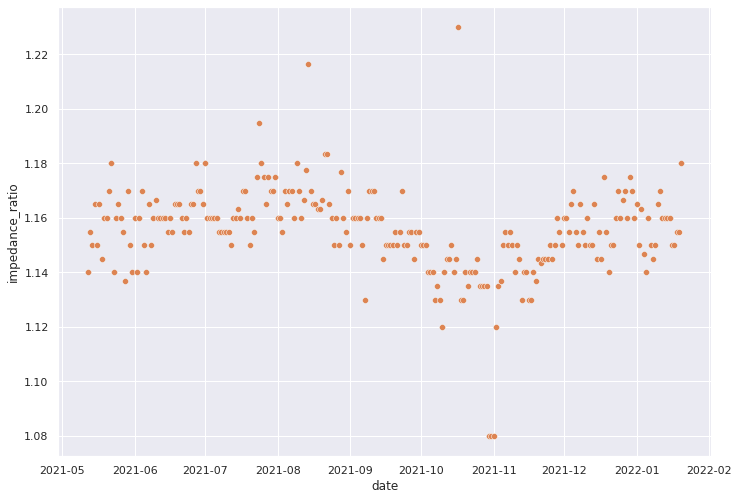

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='darkgrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data=overall_df, x="date", y="impedance_ratio")

overall_df_filled = overall_df.fillna(method="ffill")
sns.scatterplot(data=overall_df_filled, x="date", y="impedance_ratio")